In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import pandas_profiling
import scipy.stats
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures,PowerTransformer,QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.impute import KNNImputer
from scipy.stats import mstats
from scipy.stats import norm
from scipy import stats
from statsmodels.api import OLS
plt.rcParams['figure.figsize'] = 10, 10
plt.style.use('bmh')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
!pip3 install pandas-profiling==2.8.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/AirQualityUCI.csv"
df = pd.read_csv(path,sep=";",na_values="-200",decimal=",")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [ ]:
df = df.drop(columns=["Unnamed: 15","Unnamed: 16"])

In [ ]:
TARGET = "C6H6(GT)";
SEED = 42;

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


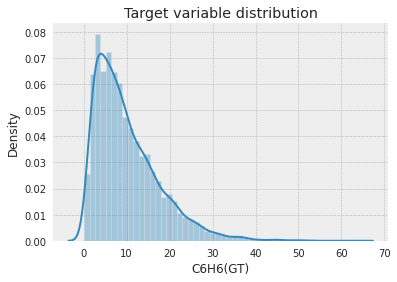

In [ ]:
ax = sns.distplot(df["C6H6(GT)"], norm_hist=True)
ax.set_title('Target variable distribution');



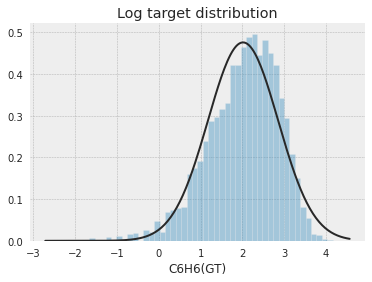

In [ ]:
ax = sns.distplot(np.log(df["C6H6(GT)"]), norm_hist=True,fit=norm,kde=False)
ax.set_title('Log target distribution');

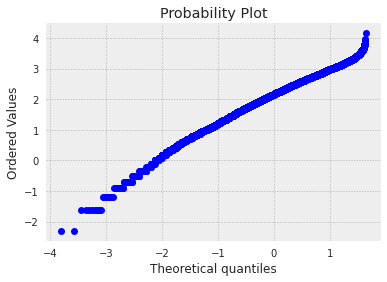

In [ ]:
res = stats.probplot(np.log(df["C6H6(GT)"]), plot=plt)

Log looks much better, but let's check SQRT one also

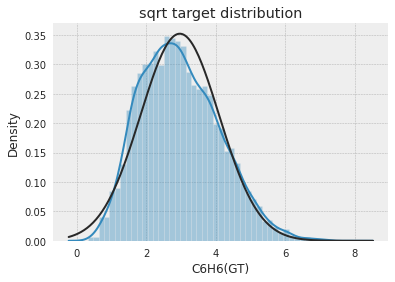

In [ ]:
ax = sns.distplot(np.sqrt(df["C6H6(GT)"]), fit=norm,norm_hist=True)
ax.set_title('sqrt target distribution');

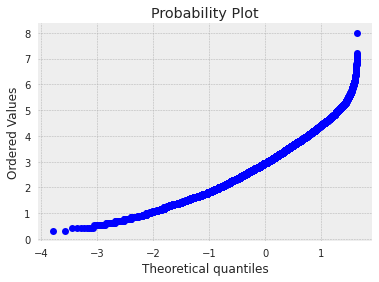

In [ ]:
res = stats.probplot(np.sqrt(df["C6H6(GT)"]), plot=plt)

Seems that in this case SQRT transormation is better, but we can try both

In [ ]:
#pandas_profiling.ProfileReport(df)

Overview of Profiling:

1) NMHC(GT) has high correlation with target, but has 90% of missing values, so this feature has to be dropped

2) Target variable is C6H6(GT) HIGHLY (nearly one) correlated with some other features

3) There are rows of NaNs that should be dropped, and not imputed 

4) All features are numeric, making it easier to preprocess

5) A lot of features has exactly the same number of missing values, which means it's likely just NaN strings with 1 or 2 not NaN value




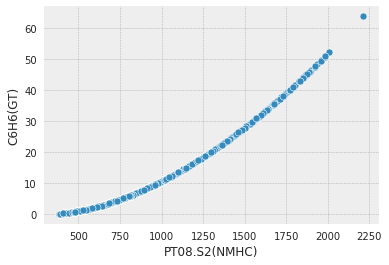

In [ ]:
#better look at highly-correlated features
ax = sns.scatterplot(data=df, x="PT08.S2(NMHC)", y="C6H6(GT)")

In [ ]:
#empty strings are useless
df.dropna(how="all",inplace=True)

#more than 90% of data is missing
df.drop(columns=["NMHC(GT)"],inplace=True)

With that high correlation may be this one feature is enough, will see later,

Let's check another feature with negative correlation

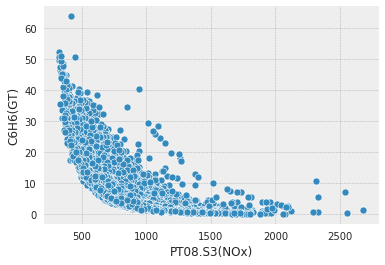

In [ ]:
#another high correlation
ax = sns.scatterplot(data=df, x="PT08.S3(NOx)", y="C6H6(GT)")

## Time analysis

In [ ]:
 #cast to dt from object
 df["Time"] = pd.to_datetime(df['Time'],format="%H.%M.%S").dt.hour #everything is :00 
Date = pd.to_datetime(df['Date'])
Date.dt.date

0       2004-10-03
1       2004-10-03
2       2004-10-03
3       2004-10-03
4       2004-10-03
           ...    
9352    2005-04-04
9353    2005-04-04
9354    2005-04-04
9355    2005-04-04
9356    2005-04-04
Name: Date, Length: 9357, dtype: object

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23')]

Text(0.5, 1.0, 'Boxplot for each hour')

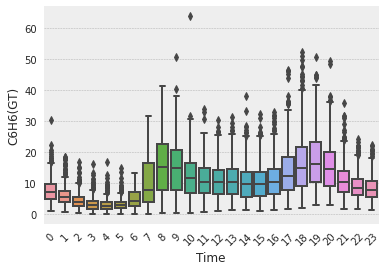

In [ ]:
p = sns.boxplot(x=df["Time"],y=df["C6H6(GT)"])
p.set_xticklabels(p.get_xticklabels(), rotation=45);
ax.set_title('Boxplot for each hour')

Time of the day really matters, but here we got a problem -- what kind of variable time is? It seems like ordinal one, because 19:00 > 06:00, but time is cyclical, which means 23:00 should be very close to 00:00, and so one.

Let's make time cyclical, transforming it's value to two new parameters "sin_time" and "cos_time". Together, they are creating time circle, where model can use the cyclycity of time

Text(0.5, 1.0, 'New values of Time toghere')

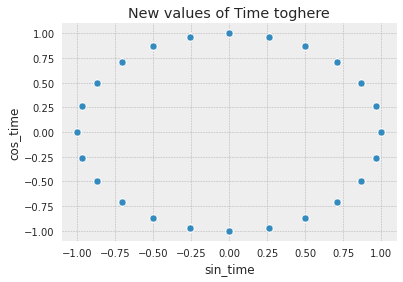

In [ ]:
df["sin_time"]  = np.sin(2*np.pi*df["Time"]/24)
df["cos_time"]  = np.cos(2*np.pi*df["Time"]/24)
df.drop(columns=["Time"],inplace=True)
ax = sns.scatterplot(x = "sin_time",y = "cos_time", data = df)
ax.set_title('New values of Time toghere')

Looks like time of the day  is realy important



Since considering specific date is useless (this date will never repeat) let's try to find some pattern in month or day of week.

In [ ]:
#create new features with int type for simplify working with Time
df["Month"] = Date.dt.month.astype(np.int64)
df["DayOfWeek"] = Date.dt.dayofweek.astype(np.int64)
df.drop(columns=["Date"],inplace=True);


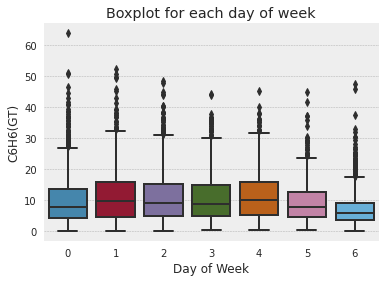

In [ ]:
ax = sns.boxplot(x=Date.dt.dayofweek,y="C6H6(GT)",data=df);
ax.set_title('Boxplot for each day of week');
ax.set_xlabel('Day of Week');

It seems like Day of Week matters -- let's check that using Kruskal-Wallis test (comparing medians)

In [ ]:
#split data among day of week -- creating an array of target variable for each Day of Week
args = [df[df["DayOfWeek"] == i][TARGET].values for i in range(0,6)]

mstats.kruskalwallis(*args)

KruskalResult(statistic=58.81273038668838, pvalue=2.137778523739574e-11)

pvalue is extremly low -> they have significantly different medians, 

same applies for months

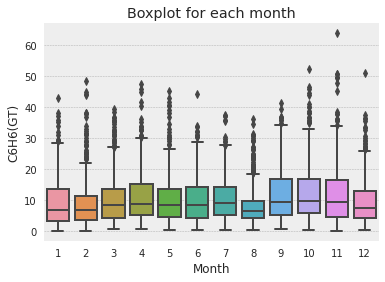

In [ ]:
ax = sns.boxplot(x=Date.dt.month,y="C6H6(GT)",data=df);

ax.set_title('Boxplot for each month');
ax.set_xlabel('Month');

# Data preparation  
Filling missing values

In [ ]:
df.dtypes

CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
sin_time         float64
cos_time         float64
Month              int64
DayOfWeek          int64
dtype: object

In [ ]:
NUMERICAL = df.select_dtypes(include=['float64']).columns.tolist()
CATEGORICAL =  df.select_dtypes(include=['int64']).columns.tolist()#the only cat-features in this df is Month and Day of week which are integers right now
if TARGET in NUMERICAL:
    NUMERICAL.remove(TARGET)

In [ ]:
df.isna().sum()

CO(GT)           1683
PT08.S1(CO)       366
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
sin_time            0
cos_time            0
Month               0
DayOfWeek           0
dtype: int64

Most of the features have *exactly* 366 missing values, including our target variable. Looks like they all are missing simultaneously. If so, there is no need to impute nearly empty string, considering target variable is also missing.

Let's check that

In [ ]:
#all string target is missing
df_null = df.loc[df["C6H6(GT)"].isnull()]
#count other missing
df_null.isna().sum()

CO(GT)            36
PT08.S1(CO)      366
C6H6(GT)         366
PT08.S2(NMHC)    366
NOx(GT)           44
PT08.S3(NOx)     366
NO2(GT)           44
PT08.S4(NO2)     366
PT08.S5(O3)      366
T                366
RH               366
AH               366
sin_time           0
cos_time           0
Month              0
DayOfWeek          0
dtype: int64

In [ ]:
df_null.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,sin_time,cos_time,Month,DayOfWeek
524,1.7,NaN,NaN,NaN,99.0,NaN,72.0,NaN,NaN,NaN,NaN,NaN,-0.500000,-0.866025,1,6
525,1.9,NaN,NaN,NaN,108.0,NaN,81.0,NaN,NaN,NaN,NaN,NaN,-0.707107,-0.707107,1,6
526,2.3,NaN,NaN,NaN,131.0,NaN,93.0,NaN,NaN,NaN,NaN,NaN,-0.866025,-0.500000,1,6
701,2.0,NaN,NaN,NaN,129.0,NaN,106.0,NaN,NaN,NaN,NaN,NaN,-0.258819,0.965926,8,2
702,2.4,NaN,NaN,NaN,154.0,NaN,109.0,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,9,5


That's it, all this features are missing in same strings, which means it's nearly empty string.

In [ ]:
#again -- dropping only because it's nearly empty strings
df = df.dropna(subset=["C6H6(GT)"])
df.isna().sum()

CO(GT)           1647
PT08.S1(CO)         0
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
sin_time            0
cos_time            0
Month               0
DayOfWeek           0
dtype: int64

In [ ]:
#let's separate in 3 parts -- train, test, validation
target = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=False, test_size = 0.2)
#shuffle false cause of time series

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  random_state=SEED, shuffle=False, test_size = 0.2)


As imputer *KNNImputer* is used due to the fact that we have relatively high correlation between features, so finding similiar group of strings to calculate the impute value must be a good prediction, since they all are connected

In [ ]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Pipeline

In [ ]:

numeric_transformer = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERICAL)
        ('cat', categorical_transformer, CATEGORICAL)
        ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipeline = Pipeline([
  ('preprocessor', preprocessor),
  ('estimator', LinearRegression())
  ])

# Baseline

RMSE is chosen over MSE and MAE cause with such correlation errors are expected to be very small, so MSE could be misleading, and since unit of measurment of target vaeriable is not stated, MAE result can't be easily interpreted and we want our model to be more sensitive to outliars.

We will use adj_R2 score since in baseline, model will consider every feature and later some of the features could be dropped, so considering complexity of the model can be more helpfull statistic.

In [ ]:
def adj_r2_score(n,p,actual,predicted): #n -- sample size, p -- amount of featuers
  x = (1-r2_score(actual, predicted))
  y = (n-1) / (n-p-1)
  return (1 - (x * y))

In [ ]:
def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)
    features_amount = pipeline['estimator'].coef_.shape[-1];
    encoded_cat_names = (pipeline['preprocessor'].transformers_[1][1].get_feature_names(CATEGORICAL))

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2_adj': [adj_r2_score(df.shape[0],features_amount,tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2_adj': [adj_r2_score(df.shape[0],features_amount,val_y, pred_val)]
        
    }),  np.append(encoded_cat_names,NUMERICAL)

In [ ]:
def evaluate_model_single(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)
    errors = (tr_y - pred_train)
    sns.scatterplot(pred_train,errors)
    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))], 
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    })

Let's try using different transformations to target var.

In [ ]:
s0 = evaluate_model(X_train, X_val, y_train, y_val, pipeline)[0] # no tranformation -- To better understand the impact of transformation in general
s1 = evaluate_model(X_train, X_val, np.log(y_train), np.log(y_val), pipeline)[0]                   # log
s2 = evaluate_model(X_train, X_val, np.sqrt(y_train), np.sqrt(y_val), pipeline)[0]                 # sqrt 
s3 = evaluate_model(X_train, X_val, stats.boxcox(y_train)[0], stats.boxcox(y_val)[0], pipeline)[0] # box-cox

In [ ]:
res = pd.concat([s0,s1, s2,s3], ignore_index=True);
res.index = ["No Tranform","Log transform","SQRT Tranform","Box-cox"];
res

,train_RMSE,train_R2_adj,val_RMSE,val_R2_adj
No Tranform,0.698140,0.991104,1.875456,0.946528
Log transform,0.108403,0.980018,0.314590,0.875524
SQRT Tranform,0.019447,0.999685,0.052196,0.998116
Box-cox,0.096715,0.994189,0.342435,0.951623


According to this results SQRT is the best. 

We got very good result in baseline model, but difference between train and val RMSE is relativly pretty high.

In [ ]:
#using the best tranform for target
s,column_names = evaluate_model(X_train, X_val, np.sqrt(y_train), np.sqrt(y_val), pipeline)

# residueal analysis

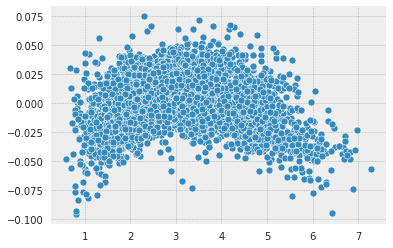

In [ ]:
X_tr = pipeline["preprocessor"].fit_transform(X_train);
pred = pipeline["estimator"].predict(X_tr)

errors = (np.sqrt(y_train) - pred)
sns.scatterplot(pred,errors)

This is pretty good distribution, but it's still  curvy

That can be fixed  with Polynominal Features.

Considering correlation between TARGET and PT08.S2(NMHC)

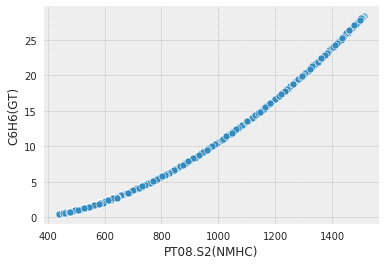

In [ ]:
#reminder
sns.scatterplot(y = TARGET,x = 'PT08.S2(NMHC)',data = df);

It just looks like a polynom with degree >=2, so may be one this feature is enough.

Let's check that

In [ ]:
pipeline = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ('estimator', LinearRegression())
    ])

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.006115,0.999969,0.007165,0.999965


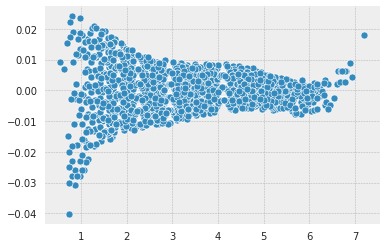

In [ ]:

X_single = np.asarray(X_train['PT08.S2(NMHC)']).reshape(-1,1);
X_single_val = np.asarray(X_val['PT08.S2(NMHC)']).reshape(-1,1);
poly = PolynomialFeatures(degree=4,include_bias=False)

X_poly_tr = poly.fit_transform((X_single))
X_poly_val = poly.fit_transform((X_single_val))
scores = evaluate_model_single(X_poly_tr, X_poly_val, np.sqrt(y_train), np.sqrt(y_val), pipeline)
scores

Usingle single polynom feature we got very good reslut, including decreseing RMSE between train and val to 12% 
Regularization is not needed this time because of the perfect fit with polynomical single feature.